# Item Nonresponse Demo

In [1]:
# To generate and store data.
import numpy as np
import pandas as pd

# To visualize data.
import matplotlib.pyplot as plt

# To fit linear regression model.
from sklearn.linear_model import LinearRegression

# Install and import missingno to visualize missingness patterns.
!pip install missingno
import missingno as msno

# There is a SciPy issue that won't affect our work, but a warning exists
# and an update is not imminent.
import warnings
warnings.filterwarnings(action="ignore")

# To render plots in the notebook.
%matplotlib inline

### Let's generate some data. Specifically, we'll generate age, partnered, children, and income data, where income is linearly related to age, partnered, and children.

In [2]:
# To ensure we get the same results.
np.random.seed(42)

# Generate data.
age = np.random.uniform(20, 60, size = 100)
partnered = np.random.binomial(1, 0.8, size = 100)
children = np.random.poisson(2, size = 100)
income = 15000 + 750 * age + 20000 * partnered - 2500 * children + np.random.normal(0, 20000, size = 100)

# Ensure income is not negative!
income = [i if i >= 0 else 0 for i in income]

# Combine our results into one dataframe.
df = pd.DataFrame({'age': age,
                   'partnered': partnered,
                   'children': children,
                   'income': income})

# Check the first five rows of df to make sure we did this properly.
df.head()

,age,children,income,partnered
0,34.981605,1,56517.564853,1
1,58.028572,2,93047.611722,1
2,49.279758,0,42902.829073,1
3,43.946339,0,83639.882744,1
4,26.240746,1,29026.080048,0


### Run this cell. These are functions that will generate missing values according to MCAR, MAR, or NMAR.

In [3]:
def create_mcar_column(df, missing_column = 'income', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are MCAR (missing completely at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        column = the name of the column in df that is missing
        p_missing = the proportion of observations that are missing
        
    Function returns:
        mcar_column = a column that indicates whether data are missing, assuming MCAR
    """
    np.random.seed(random_state)
    
    mcar_indices = [df.sample(n = 1).index[0] for i in range(round(p_missing * df.shape[0]))]
    
    while len(set(mcar_indices)) < round(p_missing * df.shape[0]):
        mcar_indices.append(df.sample(n = 1).index[0])
    
    mcar_column = [1 if i in mcar_indices else 0 for i in range(df.shape[0])]
    
    return mcar_column

def create_mar_column(df, missing_column = 'income', depends_on = 'age', method = 'linear', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are MAR (missing at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        missing_column = the name of the column in df that is missing
        depends_on = the name of the column in df which affects the missingness
        method = 'linear' or 'quadratic'
            - 'linear' means the probability of missingness is linearly related to the depends_on variable
            - 'quadratic' means the probability of missingness is quadratically related to the depends_on variable
        p_missing = the proportion of observations that are missing
        
    Function returns:
        mar_column = a column that indicates whether data are missing, assuming MAR
    """
    np.random.seed(random_state)
    
    if method == 'linear':
        mar_indices = [df.sample(n = 1, weights = depends_on).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(mar_indices)) < round(p_missing * df.shape[0]):
            mar_indices.append(df.sample(n = 1, weights = depends_on).index[0])
    
    elif method == 'quadratic':
        mar_indices = [df.sample(n = 1, weights = df[depends_on] ** 2).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(mar_indices)) < round(p_missing * df.shape[0]):
            mar_indices.append(df.sample(n = 1, weights = df[depends_on] ** 2).index[0])

    mar_column = [1 if i in mar_indices else 0 for i in range(df.shape[0])]
        
    return mar_column

def create_nmar_column(df, missing_column = 'income', method = 'linear', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are NMAR (not missing at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        missing_column = the name of the column in df that is missing
        method = 'linear' or 'quadratic'
            - 'linear' means the probability of missingness is linearly related to the depends_on variable
            - 'quadratic' means the probability of missingness is quadratically related to the depends_on variable
        p_missing = the proportion of observations that are missing
        
    Function returns:
        nmar_column = a column that indicates whether data are missing, assuming NMAR
    """
    np.random.seed(random_state)
    
    if method == 'linear':
        nmar_indices = [df.sample(n = 1, weights = missing_column).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(nmar_indices)) < round(p_missing * df.shape[0]):
            nmar_indices.append(df.sample(n = 1, weights = missing_column).index[0])
    
    elif method == 'quadratic':
        nmar_indices = [df.sample(n = 1, weights = df[missing_column] ** 2).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(nmar_indices)) < round(p_missing * df.shape[0]):
            nmar_indices.append(df.sample(n = 1, weights = df[missing_column] ** 2).index[0])
            
    nmar_column = [1 if i in nmar_indices else 0 for i in range(df.shape[0])]
    
    return nmar_column

### Let's generate some missing data!

In [4]:
df['age_missingness'] = create_mcar_column(df,
                                           missing_column = 'age',                                           
                                           p_missing = 0.3,
                                           random_state = 42)

df['partnered_missingness'] = create_mar_column(df,
                                                missing_column = 'partnered',
                                                method = 'linear',
                                                p_missing = 0.2,
                                                random_state = 42)

df['income_missingness'] = create_nmar_column(df,
                                              missing_column = 'income',
                                              method = 'quadratic',
                                              p_missing = 0.2,
                                              random_state = 42)

print(df['age_missingness'].value_counts())
print(df['partnered_missingness'].value_counts())
print(df['income_missingness'].value_counts())

0    70
1    30
Name: age_missingness, dtype: int64
0    80
1    20
Name: partnered_missingness, dtype: int64
0    80
1    20
Name: income_missingness, dtype: int64


### Let's create a new dataframe with the values actually missing.

In [5]:
df_missing = pd.DataFrame(df['children'])

df_missing['age'] = [df.loc[i,'age'] if df.loc[i,'age_missingness'] == 0 else np.nan for i in range(100)]
df_missing['partnered'] = [df.loc[i,'partnered'] if df.loc[i,'partnered_missingness'] == 0 else np.nan for i in range(100)]
df_missing['income'] = [df.loc[i,'income'] if df.loc[i,'income_missingness'] == 0 else np.nan for i in range(100)]

df_missing.head()

,children,age,partnered,income
0,1,34.981605,1.0,56517.564853
1,2,58.028572,NaN,NaN
2,0,49.279758,1.0,42902.829073
3,0,43.946339,1.0,NaN
4,1,26.240746,0.0,29026.080048


### Let's visualize our missing data.
- Children is 100% observed.
- Age is missing completely at random and is missing 30% of its observations.
- Partnered is missing at random and is missing 20% of its observations.
- Income is missing at random and is missing 20% of its observations.

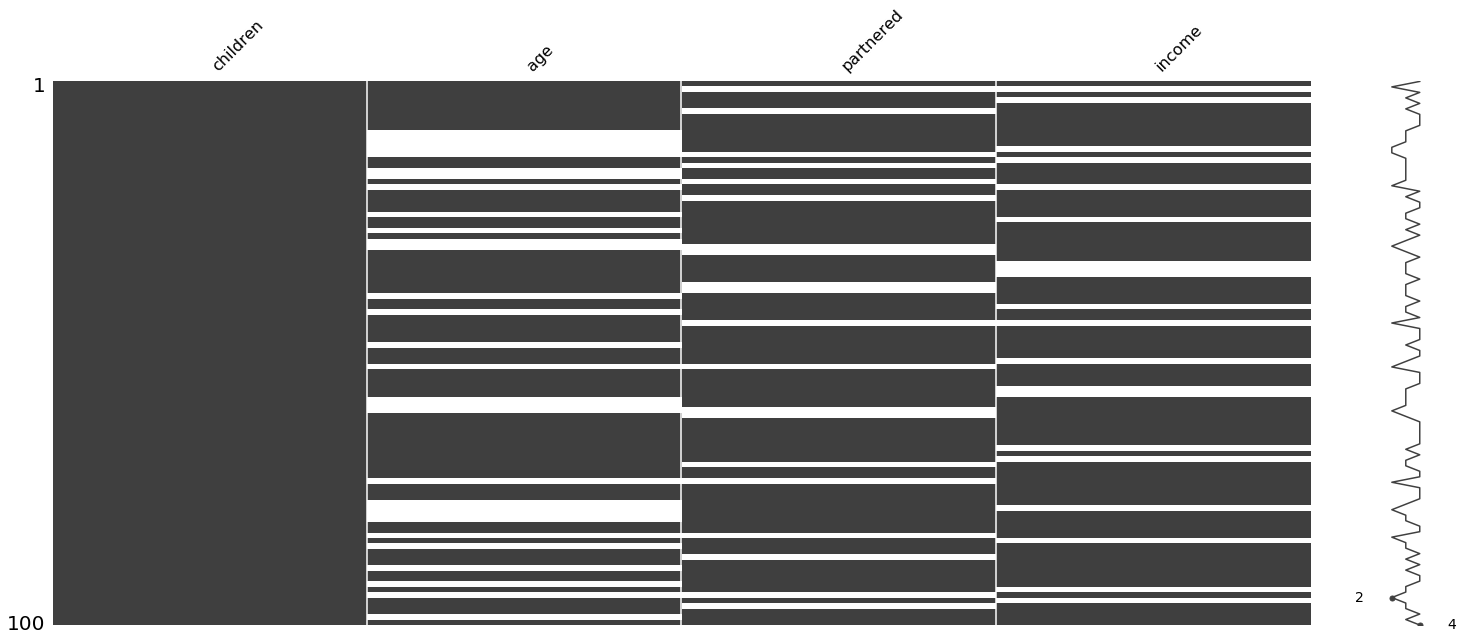

In [6]:
msno.matrix(df_missing);

### Generate bar charts/histograms.

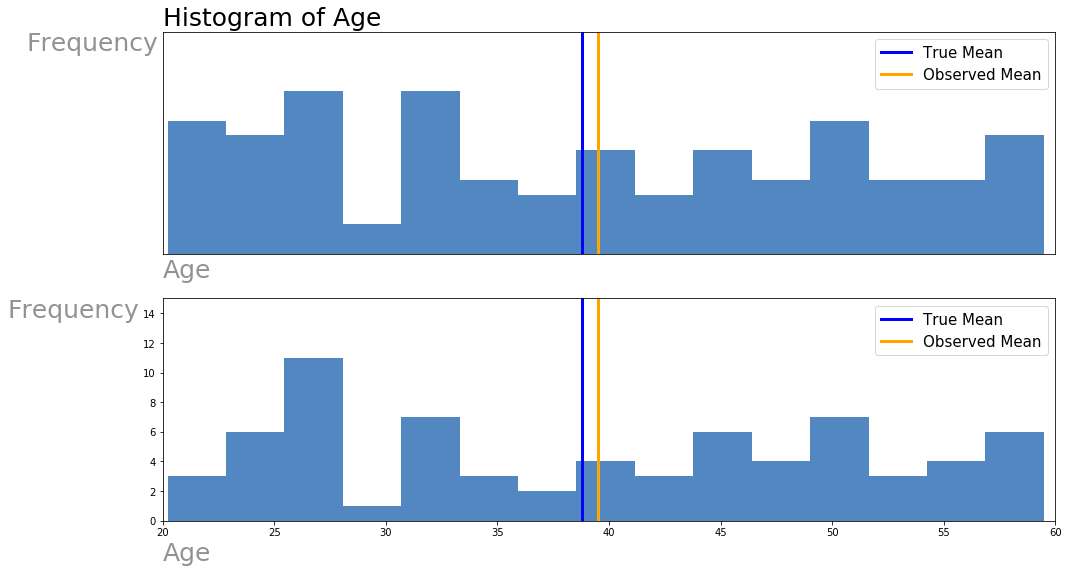

In [7]:
fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))

# Set labels and axes.
ax0.set_xlabel("Age", position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
ax0.set_ylabel("Frequency", position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
ax0.set_xlim(20,60)
ax0.set_ylim(0,15)

# Generate histogram.
ax0.hist(df['age'], bins = 15, color = '#185fad', alpha = 0.75, label = '')
ax0.set_title('Histogram of Age', position = (0,1), ha = 'left', fontsize = 25)
ax0.axvline(np.mean(df['age']), color = 'blue', lw = 3, label = 'True Mean')
ax0.axvline(np.mean(df['age'][df['age_missingness'] == 0]), color = 'orange', lw = 3, label = 'Observed Mean')
ax0.legend(prop={'size': 15}, loc = 1)

ax0.set_xticks([])
ax0.set_yticks([])

ax1.set_xlabel("Age", position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
ax1.set_ylabel("Frequency", position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
ax1.set_xlim(20,60)
ax1.set_ylim(0,15)

ax1.hist(df['age'][df['age_missingness'] == 0], bins = 15, color = '#185fad', alpha = 0.75, label = '')
ax1.axvline(np.mean(df['age']), color = 'blue', lw = 3, label = 'True Mean')
ax1.axvline(np.mean(df['age'][df['age_missingness'] == 0]), color = 'orange', lw = 3, label = 'Observed Mean')
ax1.legend(prop={'size': 15}, loc = 1)

plt.show();

In [8]:
df['age_mean_imputed'] = [df.loc[i,'age'] if df.loc[i,'age_missingness'] == 0 else np.mean(df['age']) for i in range(100)]

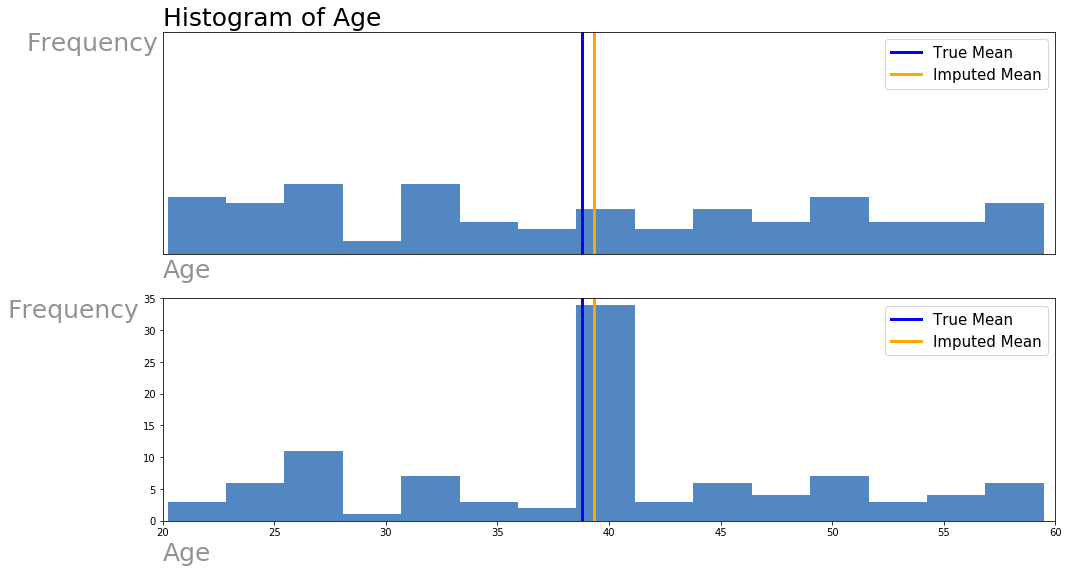

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))

# Set labels and axes.
ax0.set_xlabel("Age", position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
ax0.set_ylabel("Frequency", position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
ax0.set_xlim(20,60)
ax0.set_ylim(0,35)

# Generate histogram.
ax0.hist(df['age'], bins = 15, color = '#185fad', alpha = 0.75, label = '')
ax0.set_title('Histogram of Age', position = (0,1), ha = 'left', fontsize = 25)
ax0.axvline(np.mean(df['age']), color = 'blue', lw = 3, label = 'True Mean')
ax0.axvline(np.mean(df['age_mean_imputed']), color = 'orange', lw = 3, label = 'Imputed Mean')
ax0.legend(prop={'size': 15}, loc = 1)

ax0.set_xticks([])
ax0.set_yticks([])

ax1.set_xlabel("Age", position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
ax1.set_ylabel("Frequency", position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
ax1.set_xlim(20,60)
ax1.set_ylim(0,35)

ax1.hist(df['age_mean_imputed'], bins = 15, color = '#185fad', alpha = 0.75, label = '')
ax1.axvline(np.mean(df['age']), color = 'blue', lw = 3, label = 'True Mean')
ax1.axvline(np.mean(df['age_mean_imputed']), color = 'orange', lw = 3, label = 'Imputed Mean')
ax1.legend(prop={'size': 15}, loc = 1)

plt.show();